In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from smt.sampling_methods import LHS
from scipy.linalg import svd,solve,norm,lstsq
import scipy.ndimage
from sklearn.preprocessing import PolynomialFeatures

# Latin Hypercube Sampling

In [3]:
limits = np.array([[0.9e-3, 1.1e-3], [680.0, 700.],[590., 596.]])
sampling = LHS(xlimits=limits,random_state=1)

num = 50
x_samples = sampling(num)
print(x_samples.shape)

(50, 3)


In [137]:
##Modify the OpenLB input files accordingly.

for i in range(50):
    with open('solidification3d_stl.cpp', 'r') as input_file, open('solidification3d_stl'+str(i+1)+'.cpp', 'w') as output_file:
        counter = 0
        for line in input_file:
            
            counter += 1
            if counter == 29:
                output_file.write('const T u_inlet = '+str(x_samples[i][0])+';\n')
            elif counter == 37:
                output_file.write('const T Tcold_real = '+str(x_samples[i][2])+';\n')
            elif counter == 39:
                output_file.write('const T Thot_real = '+str(x_samples[i][1])+';\n')
            else:
                output_file.write(line)

In [4]:
##Function that extracts the solid profile from the outputs

def get_solid_profile(file):
    df = pd.read_csv(file)  

    #Let's get rid of the symmetric upper half of the slice
    df_filtered = df[df['Points:2'] <= 0.0]
    #Let's only keep the solid nodes
    df_filtered = df_filtered[df_filtered['liquid fraction'] == 0.0]
    #Sort dataframe by ascending axial position
    df_filtered = df_filtered.sort_values(by=['Points:0'])
    #Remove spurious datapoints
    df_filtered = df_filtered[df_filtered['Points:0'] < 0.5 ]

    #Find the height of the solid for each x position
    h_solid = []
    x_coord = []

    aux_x = df_filtered['Points:0'][0]
    x_coord.append(aux_x)
    aux_y = df_filtered['Points:2'][0]
    h_solid.append(aux_y)

    for x_i,y_i in zip(df_filtered['Points:0'],df_filtered['Points:2']):
        if x_i != x_coord[-1]:
            x_coord.append(x_i)
            h_solid.append(y_i)
        else:
            if y_i > h_solid[-1]:
                h_solid[-1] = y_i
    
    
    return x_coord,h_solid 

In [71]:
## Obtaining the profiles of the 40 cases

N = 40
x_data = [None] * N
data = [None] * N
for i in range(N):
    x_data[i],data[i] = get_solid_profile('Runs/'+str(i+1)+'_lf.csv')

data = np.asarray(data).T + 0.1
x_data = np.asarray(x_data[0]).T

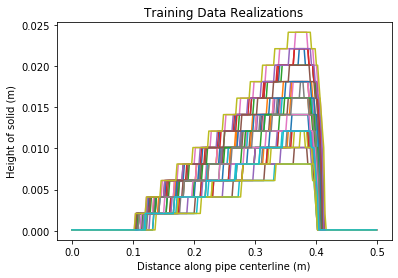

In [750]:
##Plotting the realizations
for i in range(N):
    plt.plot(x_data,data[:,i])
    
plt.xlabel("Distance along pipe centerline (m)")
plt.ylabel("Height of solid (m)")
plt.title("Training Data Realizations")
#plt.savefig("Realizations.pdf")

# SVD

The energy percentage kept is :  84.07022470221536


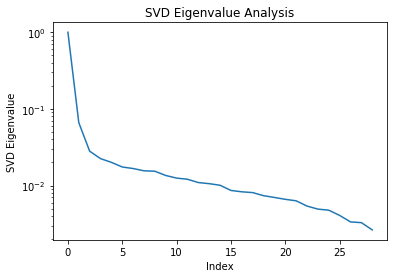

In [39]:
N_train = 30

data_train = data[:,0:N_train]
data_test = data[:,N_train:N]

#Singular Value Decomposition
U, s, VT = svd(data_train)
plt.semilogy(s[:-1]/np.max(s))

#Energy
r = 5
print("The energy percentage kept is : " , np.sum(s[0:r])/np.sum(s) * 100)

plt.xlabel("Index")
plt.ylabel("SVD Eigenvalue")
plt.title("SVD Eigenvalue Analysis")
#plt.savefig("SVDEigenvalue.pdf")

In [31]:
##Truncate the modes
U_r = U[:,:r]
U_rt = U_r.T

#Calculate c using our training data
c_train = np.zeros([r,N_train])
for i in range(N_train):
    c_train[:,i] = U_rt.dot(data_train[:,i])

In [32]:
#Training the coefficients for the polynomial expansion of c from the training data
#Select degree of expansion
d = 2
poly = PolynomialFeatures(d)

#Prepare matrix M of Eq 24 in the report
M_lstsq = poly.fit_transform(x_samples[0:N_train])

In [33]:
#Solve by least squares
#theta: rows correspond to the number of coefficients, and columns to which mode.
theta = np.zeros([len(poly.powers_),r])
for i in range(r):
    theta[:,i] = lstsq(M_lstsq,c_train[i,:])[0]

In [34]:
#Initialize
predicted_x_nonintrusive = np.zeros([len(x_data),N-N_train])
error_nonintrusive = np.zeros(N-N_train)

#Reconstruct the solutions using our ROM for the 10 testing samples and compute the error
for n in range(N_train,N):
    #Build full matrix
    realization = poly.fit_transform( x_samples[n].reshape(-1,1).T )[0]
    c_predicted = realization.dot(theta).T

    #Store ROM solution
    offset = N_train
    predicted_x_nonintrusive[:,n-offset] = U_r.dot(c_predicted)

    #Compute error
    error_nonintrusive[n-offset] = norm(predicted_x_nonintrusive[:,n-offset]-data_test[:,n-offset])/norm(data_test[:,n-offset])
print("The average error using", str(r) ,"principal modes is: ",np.mean(error_nonintrusive)*100,'%')

The average error using 5 principal modes is:  8.615671334671205 %


Text(0.5, 1.0, 'ROM tests')

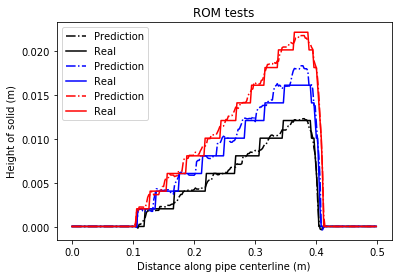

In [12]:
#Plotting some predictions
plt.plot(x_data,predicted_x_nonintrusive[:,9],'k-.',label='Prediction')
plt.plot(x_data,data_test[:,9],'k',label='Real')
plt.plot(x_data,predicted_x_nonintrusive[:,2],'b-.',label='Prediction')
plt.plot(x_data,data_test[:,2],'b',label='Real')
plt.plot(x_data,predicted_x_nonintrusive[:,3],'r-.',label='Prediction')
plt.plot(x_data,data_test[:,3],'r',label='Real')
plt.legend()

plt.xlabel("Distance along pipe centerline (m)")
plt.ylabel("Height of solid (m)")
plt.title("ROM tests")
#plt.savefig("Unprocessed_Predictions"+str(r)+".pdf")


# Smoothing using Gaussian Filter

In [110]:
#Obtaining the solid profiles of the 40 cases
x_samples = sampling(num)
N = 40
x_data = [None] * N
data = [None] * N
for i in range(N):
    x_data[i],data[i] = get_solid_profile('Runs/'+str(i+1)+'_lf.csv')

data = np.asarray(data).T + 0.1
x_data = np.asarray(x_data[0]).T

The energy percentage kept is :  95.1353022364758


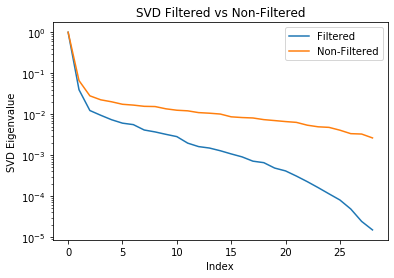

In [111]:
#Split into training and testing
N_train = 30

data_train = data[:,0:N_train]
data_test = data[:,N_train:N]

#Here we filter the raw training data
data_train_s = np.zeros(np.shape(data_train))
for i in range(N_train): 
    data_train_s[:,i] = scipy.ndimage.gaussian_filter(data_train[:,i], 5) 

#Here we filter the raw testing data
data_test_s = np.zeros(np.shape(data_test))
for i in range(N-N_train): 
    data_test_s[:,i] = scipy.ndimage.gaussian_filter(data_test[:,i], 5) 
    
#Singular Value Decomposition
U, ss, VT = svd(data_train_s)
plt.semilogy(ss[:-1]/np.max(ss),label='Filtered')
plt.semilogy(s[:-1]/np.max(s),label='Non-Filtered')
#Energy
r = 3
print("The energy percentage kept is : " , np.sum(ss[0:r])/np.sum(ss) * 100)

plt.xlabel("Index")
plt.ylabel("SVD Eigenvalue")
plt.title("SVD Filtered vs Non-Filtered")
plt.legend()
#plt.savefig("SVDFilteredvsNonFiltered.pdf")


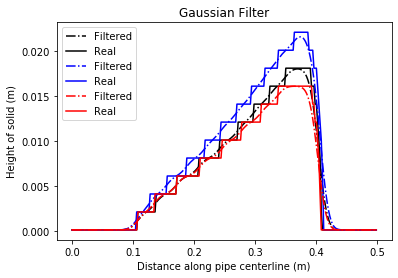

In [96]:
##Plot comparison between filtered and unfiltered
plt.plot(x_data,data_test_s[:,0],'k-.',label='Filtered')
plt.plot(x_data,data_test[:,0],'k',label='Real')
plt.plot(x_data,data_test_s[:,3],'b-.',label='Filtered')
plt.plot(x_data,data_test[:,3],'b',label='Real')
plt.plot(x_data,data_test_s[:,4],'r-.',label='Filtered')
plt.plot(x_data,data_test[:,4],'r',label='Real')

plt.xlabel("Distance along pipe centerline (m)")
plt.ylabel("Height of solid (m)")
plt.title("Gaussian Filter")
plt.legend()
#plt.savefig("Processed_Examples.pdf")


In [112]:
#Truncate modes
U_r = U[:,:r]
U_rt = U_r.T

#Calculate c using the training set
c_train = np.zeros([r,N_train])
for i in range(N_train):
    c_train[:,i] = U_rt.dot(data_train_s[:,i])

In [113]:
#Training the coefficients for the polynomial expansion of c from the training data
#Select degree of expansion
d = 2
poly = PolynomialFeatures(d)

#Prepare matrix M
M_lstsq = poly.fit_transform(x_samples[0:N_train])

In [114]:
#Solve by least squares
#theta: rows correspond to the number of coefficients, and columns to which mode.
theta = np.zeros([len(poly.powers_),r])
for i in range(r):
    theta[:,i] = lstsq(M_lstsq,c_train[i,:])[0]

In [115]:
#Initialize
predicted_x_nonintrusive = np.zeros([len(x_data),N-N_train])
error_nonintrusive = np.zeros(N-N_train)
#Reconstruct solution
for n in range(N_train,N):
    #Build full matrix
    realization = poly.fit_transform( x_samples[n].reshape(-1,1).T )[0]
    c_predicted = realization.dot(theta).T

    #Store ROM solution
    offset = N_train
    predicted_x_nonintrusive[:,n-offset] = U_r.dot(c_predicted)

    #Compute error
    error_nonintrusive[n-offset] = norm(predicted_x_nonintrusive[:,n-offset]-data_test_s[:,n-offset])/norm(data_test[:,n-offset])
print("The average error using", str(r) ,"principal modes is: ",np.mean(error_nonintrusive)*100,'%')

The average error using 3 principal modes is:  5.135624477007941 %


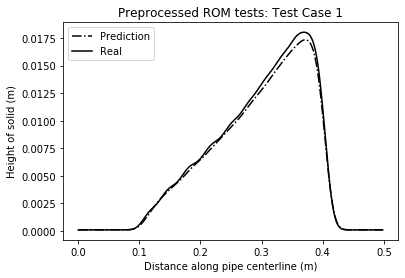

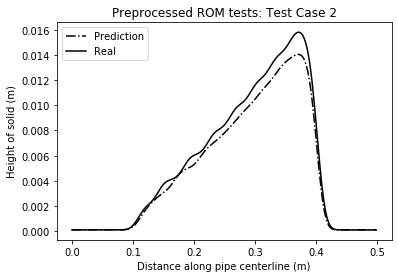

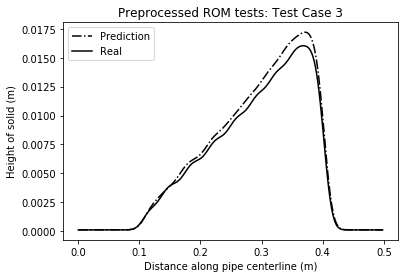

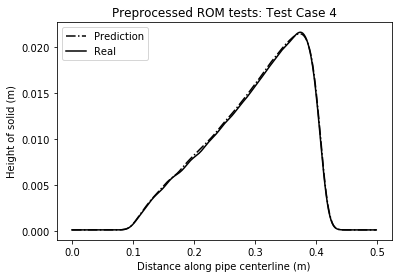

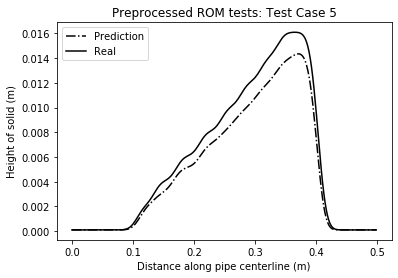

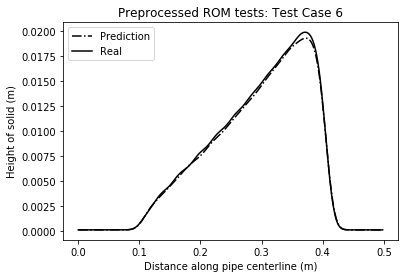

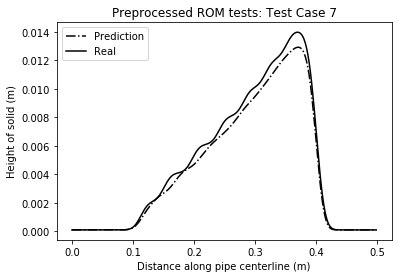

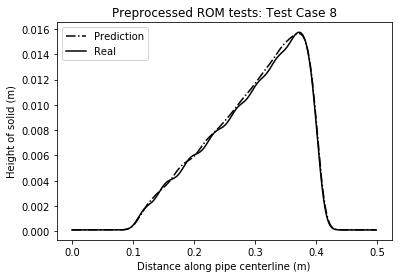

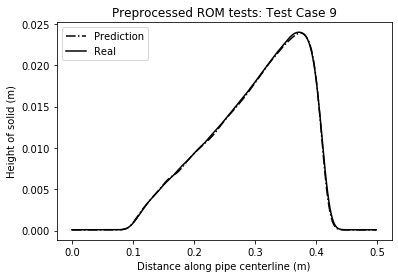

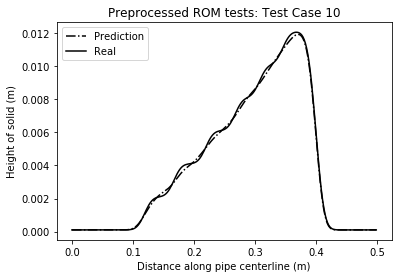

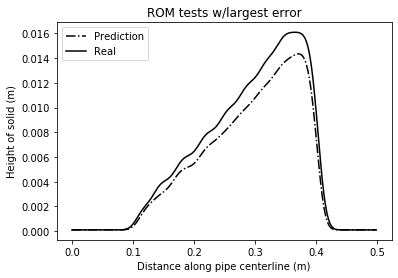

In [118]:
#Plot predictions and testing data
for i in range(N-N_train):
    plt.figure(i)
    plt.plot(x_data,predicted_x_nonintrusive[:,i],'k-.',label='Prediction')
    plt.plot(x_data,data_test_s[:,i],'k',label='Real')
    plt.xlabel("Distance along pipe centerline (m)")
    plt.ylabel("Height of solid (m)")
    plt.legend()
    plt.title("Preprocessed ROM tests: Test Case "+str(i+1))
    #plt.savefig("PreProcessed_Predictions"+str(i+1)+".pdf")


In [ ]:
#Showcase worst prediction    
plt.figure()
plt.plot(x_data,predicted_x_nonintrusive[:,4],'k-.',label='Prediction')
plt.plot(x_data,data_test_s[:,4],'k',label='Real')
plt.xlabel("Distance along pipe centerline (m)")
plt.ylabel("Height of solid (m)")
plt.title("ROM tests w/largest error")
plt.legend()
#plt.savefig("SelectedCase.pdf")

# Smothing + Adding the largest error test case to the training set 

In [119]:
x_samples = sampling(num)
N = 40
x_data = [None] * N
data = [None] * N
for i in range(N):
    x_data[i],data[i] = get_solid_profile('Runs/'+str(i+1)+'_lf.csv')

data = np.asarray(data).T + 0.1
x_data = np.asarray(x_data[0]).T

# This swap is done after post analysis. The case 34 had the largest error when predicting with the surrogate
# model. So it was added to the training set.
data[:, [34, 0]] = data[:, [0, 34]]
x_samples[[34, 0]] = x_samples[[0, 34]]

The energy percentage kept is :  99.5317678464805


Text(0, 0.5, 'SVD Eigenvalue')

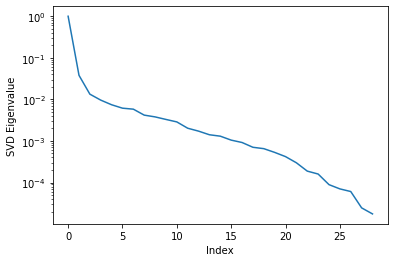

In [136]:
N_train = 30

data_train = data[:,0:N_train]
data_test = data[:,N_train:N]

data_train_s = np.zeros(np.shape(data_train))
#data_train_s = np.zeros([int(len(x_data)/2),N_train])
for i in range(N_train): 
    data_train_s[:,i] = scipy.ndimage.gaussian_filter(data_train[:,i], 5) 

data_test_s = np.zeros(np.shape(data_test))
#data_test_s = np.zeros([int(len(x_data)/2),N-N_train])
for i in range(N-N_train): 
    data_test_s[:,i] = scipy.ndimage.gaussian_filter(data_test[:,i], 5) 
    
#Singular Value Decomposition
U, ss, VT = svd(data_train_s)
plt.semilogy(ss[:-1]/np.max(ss))
#Energy
r = 15
print("The energy percentage kept is : " , np.sum(ss[0:r])/np.sum(ss) * 100)

plt.xlabel("Index")
plt.ylabel("SVD Eigenvalue")
#plt.savefig("SVDFilteredvsNonFiltered.pdf")

In [137]:
U_r = U[:,:r]
U_rt = U_r.T

#Calculate c
c_train = np.zeros([r,N_train])
for i in range(N_train):
    #c_train[:,i] = U_rt.dot(data_train[:,i])
    c_train[:,i] = U_rt.dot(data_train_s[:,i])

In [138]:
#Training the coefficients for the polynomial expansion of c from the training data
#Select degree of expansion
d = 2
poly = PolynomialFeatures(d)

#Prepare matrix M
M_lstsq = poly.fit_transform(x_samples[0:N_train])

In [139]:
#Solve by least squares
#theta: rows correspond to the number of coefficients, and columns to which mode.
theta = np.zeros([len(poly.powers_),r])
for i in range(r):
    theta[:,i] = lstsq(M_lstsq,c_train[i,:])[0]

In [140]:
#Initialize
predicted_x_nonintrusive = np.zeros([len(x_data),N-N_train])
#predicted_x_nonintrusive = np.zeros([int(len(x_data)/2),N-N_train])
error_nonintrusive = np.zeros(N-N_train)
#Reconstruct 
for n in range(N_train,N):
    #Build full matrix
    realization = poly.fit_transform( x_samples[n].reshape(-1,1).T )[0]
    c_predicted = realization.dot(theta).T

    #Store ROM solution
    offset = N_train
    predicted_x_nonintrusive[:,n-offset] = U_r.dot(c_predicted)

    #Compute error
    error_nonintrusive[n-offset] = norm(predicted_x_nonintrusive[:,n-offset]-data_test_s[:,n-offset])/norm(data_test[:,n-offset])
print("The average error using", str(r) ,"principal modes is: ",np.mean(error_nonintrusive)*100,'%')

The average error using 15 principal modes is:  3.578466317815386 %


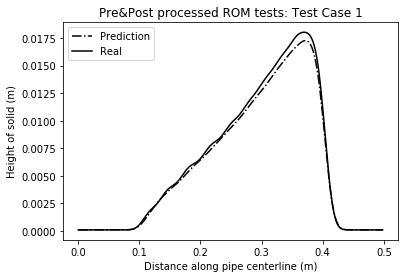

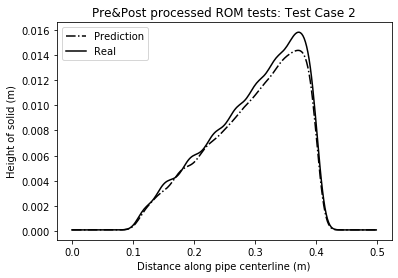

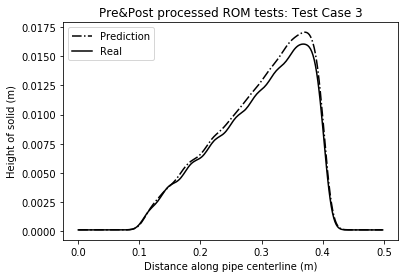

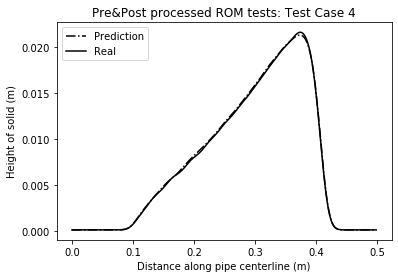

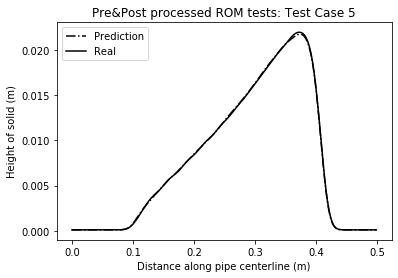

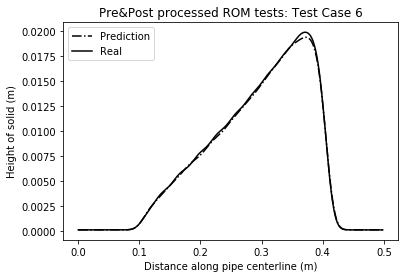

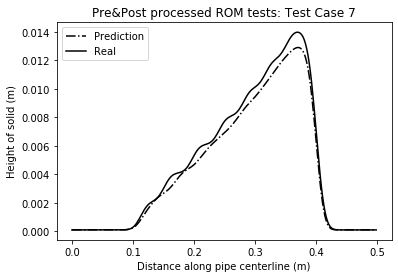

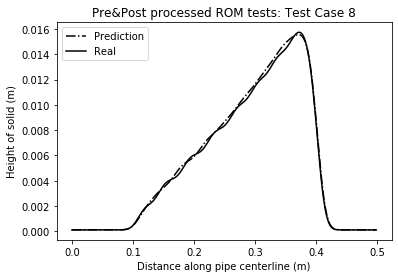

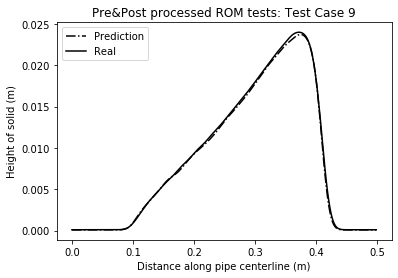

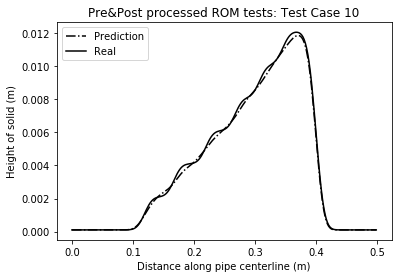

In [108]:
for i in range(N-N_train):
    plt.figure(i)
    plt.plot(x_data,predicted_x_nonintrusive[:,i],'k-.',label='Prediction')
    plt.plot(x_data,data_test_s[:,i],'k',label='Real')
    plt.xlabel("Distance along pipe centerline (m)")
    plt.ylabel("Height of solid (m)")
    plt.legend()
    plt.title("Pre&Post processed ROM tests: Test Case "+str(i+1))
    plt.savefig("PrePostProcessed_Predictions"+str(i+1)+".pdf")

# Figures and postprocessing

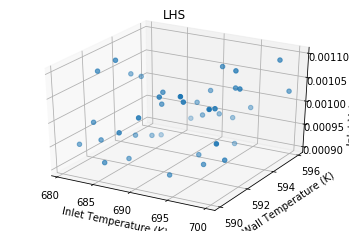

In [4]:
from mpl_toolkits import mplot3d
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axes
z = x_samples[:40,0]
x = x_samples[:40,1]
y = x_samples[:40,2]
 
# plotting
ax.scatter(x, y, z, 'green')
ax.locator_params(axis='x',nbins=5)
ax.locator_params(axis='y',nbins=5)
ax.locator_params(axis='z',nbins=5)
ax.set_xlabel("Inlet Temperature (K)")
ax.set_ylabel("Wall Temperature (K)")
ax.set_zlabel("\nInlet Velocity (m/s)")
ax.set_title('LHS')

fig.savefig("LHS.pdf")